# Test technique Yanport du 21 Août 2023
Chih-Kang HUANG

## Objectif : 

Nous vous proposons de regrouper les annonces immobilières portant sur un même bien immobilier. En effet, plusieurs professionnels (voire particuliers) publient sur plusieurs portails immobiliers des annonces portant sur le même bien immobilier et il y a un intérêt fort de les dédoublonner pour rendre la recherche plus efficace mais aussi pour avoir des statistiques plus pertinentes. 



La stratégie repose sur une méthode hybride, combinant des comparaisons classiques et une analyse de texte de base à l'aide d'un modèle de langage.

**Hypothèse** : Dans ce document, nous supposons qu'il n'y a ni de fausses saisies ni de fausses annonces. Nous aborderons ce point de vue à la conclusion de ce document et proposerons quelques pistes d'amélioration éventuelles.

Les étapes clés sont les suivantes :

1. Après avoir minutieusement analysé et nettoyé nos données, nous commençons par identifier les caractéristiques essentielles qui permettent de déterminer si deux annonces sont très probablement identiques ou différentes. Nous classifions principalement ces caractéristiques en trois catégories : liens, catégoriques et numériques.

2. Nous exploitons un modèle de langage avancé sur la colonne "DESCRIPTION" afin de quantifier les similitudes entre deux textes.
    
3. Enfin, en utilisant les fonctions de critères que nous avons élaborées précédemment, nous créons un nouveau DataFrame avec une colonne de clés d'identification. Cette clé nous permettra de regrouper facilement les annonces décrivant le même bien immobilier.

In [1]:
## Only for google Colab 
#!pip install huggingface_hub
#!pip install transformers sentencepiece protobuf tokenizer
#
#from google.colab import drive
#
#drive.mount('/content/drive'
#======================================================

# Chargement des biliothèques dont nous aurions besoin :
import pandas as pd
import numpy as np

# helpful modules
import json # change string to list/dictionnary
import matplotlib.pyplot as plt
import seaborn as sns # data visualization

# CrossEncoder pour le traitement automatique du langage
from sentence_transformers import CrossEncoder

# import fuzzywuzzy
# from fuzzywuzzy import process
# import charset_normalizer

# Zero-shot Classification
# from transformers import pipeline
# from huggingface_hub import notebook_login
# 
# notebook_login()
# 
# classifier = pipeline("zero-shot-classification",
#                       model="joeddav/xlm-roberta-large-xnli")
#classifier = pipeline("zero-shot-classification",
#                      model="joeddav/xlm-roberta-large-xnli", device=0) # GPU


Lors du chargement d'un fichier CSV en tant que DataFrame à l'aide de *Pandas*, il est essentiel de prendre en compte les problèmes potentiels liés à l'encodage. Cela se produit fréquemment dans les pays où les langues utilisées ne sont pas basées sur l'alphabet standard :

In [2]:
data_path = "./Dataset - Ads _ Levallois-Perret - 2019-08 - export-ads-levallois-perret-2019-08-27.csv"
df = pd.read_csv(data_path, encoding="utf-8")
df.head(10)

,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,...,DEALER_NAME,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,http://www.avendrealouer.fr/location/levallois...,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...","[""https://cf-medias.avendrealouer.fr/image/_87...",72.00,NaN,NaN,...,Lamirand Et Associes,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-03-22T04:07:56.095,NaN,2017-04-21T18:52:35.733,NaN
1,8d092fa0-bb99-11e8-a7c9-852783b5a69d,https://www.bienici.com/annonce/ag440414-16547...,BIEN_ICI,APARTMENT,False,Je vous propose un appartement dans la rue Col...,"[""http://photos.ubiflow.net/440414/165474561/p...",48.00,NaN,NaN,...,Proprietes Privees,MANDATARY,54178039,Levallois-Perret,92300.0,92,2018-09-18T11:04:44.461,NaN,2019-06-06T10:08:10.89,2018-09-25
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...","[""https://v.seloger.com/s/width/965/visuels/0/...",267.00,NaN,NaN,...,Propriétés Parisiennes,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-02-19T16:49:03.547,NaN,2019-06-13T08:22:14.314,NaN
3,e9e07ed0-812f-11e8-82aa-61eacebe4584,https://www.seloger.com/annonces/locations/bur...,SE_LOGER,PREMISES,False,"""Le meilleur coworking flexible de la ville, 5...","[""https://pix.yanport.com/ads/e9e07ed0-812f-11...",50.00,NaN,NaN,...,Iwg,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-07-06T15:18:59.805,NaN,2019-06-18T10:40:07.405,NaN
4,872302b0-5a21-11e9-950c-510fefc1ed35,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,HOUSE,False,Levallois - Parc de la Planchette A toute prox...,"[""https://v.seloger.com/s/width/966/visuels/0/...",330.00,NaN,NaN,...,Daniel Feau Neuilly,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-04-08T17:12:20.123,NaN,2019-06-14T15:02:18.155,2019-06-14
5,de04afa0-2e5f-11e8-bda5-3334b193df7f,https://immobilier.lefigaro.fr/annonces/annonc...,EXPLORIMMO,APARTMENT,False,LEVALLOIS - FRONT DE SEINE - 5-6 PIECES Appart...,"[""http://photo3.pericles.fr/photo_get.php?S1=3...",142.76,NaN,NaN,...,Building Partners,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-03-23T06:03:10.963,NaN,2019-07-10T15:06:39.615,NaN
6,530c7ac0-36a5-11e7-a435-b3bf21527190,https://www.seloger.com/annonces/locations/bur...,SE_LOGER,PREMISES,False,"LEVALLOIS, Paul Vaillant Couturier, près gare ...","[""https://v.seloger.com/s/cdn/x/visuels/2/2/r/...",63.00,NaN,NaN,...,Cabinet De L''ouest Parisien,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-04-27T01:35:00.674,NaN,2019-07-10T15:06:17.12,2019-07-10
7,5135e0a0-62dd-11e8-91b3-8d7b603ef3b8,https://immobilier.lefigaro.fr/annonces/annonc...,EXPLORIMMO,PARKING,NaN,Louez au mois un parking privé au 2 rue Mauric...,"[""http://photos.ubiflow.net/751982/151820943/p...",16.00,NaN,NaN,...,Yespark,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-05-29T01:12:11.485,NaN,2019-07-10T02:46:51.652,NaN
8,bc076370-45ec-11e9-a00a-897941d6ca9c,https://www.leboncoin.fr/locations/1583612210.htm,LE_BON_COIN,PARKING,NaN,LOUE place de parking dans résidence de standi...,"[""https://pix.yanport.com/ads/bc076370-45ec-11...",11.00,NaN,NaN,...,baudoin,PRIVATE,54178039,Levallois-Perret,92300.0,92,2019-03-14T00:04:24.651,NaN,2019-07-13T11:03:51.699,NaN
9,08491e50-8dfe-11e9-8a42-a16638394d93,https://www.leboncoin.fr/ventes_immobilieres/1...,LE_BON_COIN,APARTMENT,False,A VENDRE APPARTEMENT DE 2 PIÈCES MAIRIE DE LEV...,"[""https://pix.yanport.com/ads/08491e50-8dfe-11...",57.00,NaN,NaN,...,Impact Immo,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-06-13T17:09:20.737,NaN,2019-07-13T18:17:01.782,2019-07-13


Nous observons dans le DataFrame que certaines cellules ne sont pas remplies, affichant plutôt la valeur NaN 

In [3]:
a, b  = df.shape
missing_value_count = df.isnull().sum()
nb_empty_cases = missing_value_count.sum()/(a*b)
print ("La taille des données est de", df.shape, "\n il y a {} de cellules non remplies".format(missing_value_count.sum()), ", soit {}% des cases non remplis".format(100* nb_empty_cases))

La taille des données est de (2164, 57) 
 il y a 64386 de cellules non remplies , soit 52.19865745695107% des cases non remplis


In [4]:
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('bool'), dtype('int64')],
      dtype=object)

In [5]:
df.nunique()

ID                            2164
URL                           2164
CRAWL_SOURCE                    13
PROPERTY_TYPE                    5
NEW_BUILD                        2
DESCRIPTION                   1914
IMAGES                        1947
SURFACE                        454
LAND_SURFACE                     2
BALCONY_SURFACE                  0
TERRACE_SURFACE                 18
ROOM_COUNT                      11
BEDROOM_COUNT                    7
BATHROOM_COUNT                   0
LUNCHROOM_COUNT                  0
TOILET_COUNT                     0
FURNISHED                        2
FIREPLACE                        0
AIR_CONDITIONING                 0
GARDEN                           1
SWIMMING_POOL                    1
BALCONY                          0
TERRACE                          1
CELLAR                           0
PARKING                          2
PARKING_COUNT                    8
HEATING_TYPES                    5
HEATING_MODE                     3
FLOOR               

In [6]:
df.shape

(2164, 57)

## Traitement des données


Commencer par les étapes essentielles du traitement des données (Data Processing), en procédant aux étapes suivantes :

1. Éliminer les colonnes non remplies ou ayant peu d'utilité.

2. Identifier les colonnes de type liste/dictionnaire et les colonnes numériques.

3. Remplir les valeurs manquantes (par exemple, FEES -> FEES_INCLUDED, RENTAL -> INCLUDED) et assurer la cohérence entre SURFACE, PRICE, PRICE_M2, PRICE_EVENT, et CRAWL_DATE.

4. Compléter les valeurs manquantes dans la colonne DESCRIPTION.

### 1. Élimination des colonnes peu utiles

Commençons par supprimer les colonnes qui ne contiennent aucune donnée :

In [7]:
useless_cols = [cname for cname in df.columns if df[cname].nunique() ==0]


ainsi que la colonne "CRAWL_SOURCE" :

In [8]:
X = df.copy().drop(useless_cols, axis =1).drop(["CRAWL_SOURCE"], axis=1)

Les colonnes qui ne contiennent qu'une seule valeur, telles que CITY, CITY_ID, ZIP_CODE, sont généralement peu informatives. Le même constat s'applique aux autres colonnes qui affichent également une unique valeur :

In [9]:
one_value_cols = [cname for cname in X.columns if X[cname].nunique() ==1]
print(one_value_cols)

['GARDEN', 'SWIMMING_POOL', 'TERRACE', 'CITY_ID', 'CITY', 'ZIP_CODE', 'DEPT_CODE']


**Dans le cadre de notre étude**, nous avons pris la décision de laisser de côté ces colonnes, même si certaines d'entre elles pourraient éventuellement être utiles en relation avec les colonnes images (bien que nous n'envisagions pas non plus de procéder à la visualisation des photos, comme cela sera expliqué ultérieurement).

In [10]:
X = X.drop(one_value_cols, axis=1)
X.shape

(2164, 38)

### 2.  Identification des colonnes de type liste et Rectification des types

Il n'y a pas beaucoup de colonnes de type liste, nous pouvons les extraire en utilisant le module **json.loads**. Elles comprennent :

In [11]:
["URL", "IMAGES", "HEATING_TYPE", "PRICE_EVENTS"]

['URL', 'IMAGES', 'HEATING_TYPE', 'PRICE_EVENTS']

Certaines colonnes numériques, telles que "FLOOR", "CONSTRUCTION_YEAR", "PARKING_COUNT", etc., sont en réalité plutôt catégoriques. Nous avons tendance à les traiter comme des chaînes de caractères au lieu de les modifier. Nous corrigeons donc leur type :

In [12]:
X["CONSTRUCTION_YEAR"] = X["CONSTRUCTION_YEAR"].astype('object')
X["FLOOR"] = X["FLOOR"].astype('object')
for cname in X.columns:
    if "COUNT" in cname:
        X[cname] = X[cname].astype('object')

### 3. Cohérences entre certaines colonnes

* RENTAL_EXPENSES, FEES

Nous définissons "True" pour RENTAL_EXPENSES_INCLUDED et "FEES_INCLUDED" si le montant est effectivement indiqué dans les colonnes correspondantes :


In [13]:
for i in X.index :
    if pd.notnull(X.loc[i, "RENTAL_EXPENSES"]):
        X.loc[i, "RENTAL_EXPENSES_INCLUDED"] = True
    if pd.notnull(X.loc[i, "FEES"]):
        X.loc[i, "FEES_INCLUDED"] = True

Exemple : FEES_INCLUDED était à NaN alors que la valeur de FEES était bien renseignée pour l'annonce 115 :

In [14]:
X.loc[115, "FEES"], X.loc[115, "FEES_INCLUDED"]

(823.5, True)


* SURFACE, PRICE, PRICE_M2, PRICE_EVENTS et DATES

Les colonnes "SURFACE", "PRICE" et "PRICE_M2" de certaines entrées sont soit bien remplies, soit présentent un grand nombre de valeurs manquantes, ce qui rend leur restitution difficile :

In [15]:
s = []
for i in X.index:
    k = pd.isnull(X.loc[i, "SURFACE"])+ pd.isnull(X.loc[i, "PRICE"]) + pd.isnull(X.loc[i, "PRICE_M2"])
    if k == 1:
        s.append(str(k))
print(s)

[]


Heuresuement, les champs PRICE_EVENTS sont dûrement remplies :

In [16]:
X["PRICE_EVENTS"].isnull().any()

False

### Cohérence entre PRICE et PRICE_EVENTS: 

Les prix indiqués dans "PRICE" sont-ils correctement enregistrés dans "PRICE_EVENTS" ?

In [17]:
X["PRICE"].isnull().sum()

60

Nous identifions les annonces dont les valeurs de "PRICE" ne sont pas enregistrées dans "PRICE_EVENTS".

In [18]:
price_not_in_event = []
price_good = 0
for i in X.index:
    price = X.loc[i, "PRICE"]
    price_events = json.loads(X.loc[i, "PRICE_EVENTS"]) # list of dictionaries
    price_list = [k["price"] for k in price_events]
    if pd.isnull(price) or (price in price_list):
        pass
    else:
      price_not_in_event.append(i)
print(price_not_in_event)

[65, 1113, 1258]


Nous plaçons ici les prix dans "PRICE_EVENTS" en tenant compte de la "LAST_CRAWL_DATE".

In [19]:
X.loc[price_not_in_event, ["PRICE", "PRICE_EVENTS", ]]


,PRICE,PRICE_EVENTS
65,48893.0,"[{""price"":48868.0,""date"":""2019-07-25""}]"
1113,29269.0,"[{""price"":72058.0,""date"":""2018-01-11""},{""price..."
1258,1227200.0,"[{""price"":1180000.0,""date"":""2019-07-30""},{""pri..."


In [20]:
CRAWLDATE = pd.to_datetime(X["LAST_CRAWL_DATE"], format='mixed').dt.date

In [21]:
CRAWLDATE[0].strftime("%Y-%m-%d")

'2017-04-21'

In [22]:
correct_price_events = []
for i in price_not_in_event :
    price = X.loc[i, "PRICE"]
    crawl_date = CRAWLDATE[i].strftime("%Y-%m-%d")
    price_dict = {"price": price,"date":crawl_date}
    event_list = json.loads(X.loc[i, "PRICE_EVENTS"]) + [price_dict]
    correct_price_events += [event_list]

correct_price_events[0]

[{'price': 48868.0, 'date': '2019-07-25'},
 {'price': 48893.0, 'date': '2019-08-14'}]

In [23]:
for i in range(len(price_not_in_event)):
    X.loc[price_not_in_event[i], "PRICE_EVENTS"] = json.dumps(correct_price_events[i])

Étant donné que nous nous assurons que la colonne "PRICE_EVENTS" contient les informations les plus récentes, certaines colonnes deviennent redondantes et sont donc retirées de notre étude :

In [24]:
X = X.drop(["PUBLICATION_START_DATE", "LAST_CRAWL_DATE", "PRICE", "LAST_PRICE_DECREASE_DATE"], axis=1)

### 4. DESCRIPTION

On remplit les cellules vides avec fillna:

In [25]:
X['DESCRIPTION'].isnull().sum()

4

In [26]:
X['DESCRIPTION'] = X['DESCRIPTION'].fillna('0')

## Classification des colonnes caractéristiques et de leur fiabilité

Dans cette section, nous allons discuter des colonnes caractéristiques, de leurs types et de leur fiabilité. Commençons par les connaître :

In [27]:
X.columns

Index(['ID', 'URL', 'PROPERTY_TYPE', 'NEW_BUILD', 'DESCRIPTION', 'IMAGES',
       'SURFACE', 'LAND_SURFACE', 'TERRACE_SURFACE', 'ROOM_COUNT',
       'BEDROOM_COUNT', 'FURNISHED', 'PARKING', 'PARKING_COUNT',
       'HEATING_TYPES', 'HEATING_MODE', 'FLOOR', 'FLOOR_COUNT',
       'CONSTRUCTION_YEAR', 'ELEVATOR', 'CARETAKER', 'MARKETING_TYPE',
       'PRICE_M2', 'PRICE_EVENTS', 'RENTAL_EXPENSES',
       'RENTAL_EXPENSES_INCLUDED', 'DEPOSIT', 'FEES', 'FEES_INCLUDED',
       'EXCLUSIVE_MANDATE', 'AGENCIES_UNWANTED', 'OCCUPIED', 'DEALER_NAME',
       'DEALER_TYPE'],
      dtype='object')

In [28]:
len(X.columns)

34

In [29]:
X.dtypes

ID                           object
URL                          object
PROPERTY_TYPE                object
NEW_BUILD                    object
DESCRIPTION                  object
IMAGES                       object
SURFACE                     float64
LAND_SURFACE                float64
TERRACE_SURFACE             float64
ROOM_COUNT                   object
BEDROOM_COUNT                object
FURNISHED                    object
PARKING                        bool
PARKING_COUNT                object
HEATING_TYPES                object
HEATING_MODE                 object
FLOOR                        object
FLOOR_COUNT                  object
CONSTRUCTION_YEAR            object
ELEVATOR                     object
CARETAKER                    object
MARKETING_TYPE               object
PRICE_M2                    float64
PRICE_EVENTS                 object
RENTAL_EXPENSES             float64
RENTAL_EXPENSES_INCLUDED     object
DEPOSIT                     float64
FEES                        

### Colonnes "ID", "URL" et "IMAGES" :

* "ID" : Nous utilisons "ID" pour générer les clés de regroupement. Nous vérifions si chaque annonce a un "ID" différent.
* "URL" : De nature similaire à "ID".

In [30]:
X["ID"].nunique() == len(X.index),  X["URL"].nunique() == len(X.index)

(True, True)

In [31]:
id_cols = ["ID", "URL"]

*    "IMAGES" : Il est très probable que deux annonces se rapportent au même bien immobilier si leurs liens "IMAGES" ont une intersection non nulle. 

Cependant, certaines annonces ne contiennent qu'une image de type publicité, par exemple :

In [32]:
image_cols = ["IMAGES"]

In [33]:
X.loc[26, "IMAGES"], X.loc[687, "IMAGES"]

('["https://v.seloger.com/s/cdn/x/visuels/1/r/y/p/1ryphs9d2l7xv8w1s80a8t7csl6d49ed62tw60lic.jpg"]',
 '["https://v.seloger.com/s/cdn/x/visuels/1/r/y/p/1ryphs9d2l7xv8w1s80a8t7csl6d49ed62tw60lic.jpg"]')

### Colonne Description :

Nous allons utiliser un modèle de langage pour traiter les descriptions des annonces. Nous détaillerons cela ultérieurement :

In [34]:
desc_cols = ["DESCRIPTION"]

### Colonnes Catégoriques :

* Colonnes Booléennes : Certaines colonnes sont de nature booléenne, et nous pouvons comparer les valeurs associées une par une :

In [35]:
bool_cols = [cname for cname in X.columns if (X[cname].nunique() == 2) and (X[cname].dtype in ['bool', 'boolean', 'object'])]
print(bool_cols)
print(len(bool_cols))

['NEW_BUILD', 'FURNISHED', 'PARKING', 'ELEVATOR', 'CARETAKER', 'MARKETING_TYPE', 'RENTAL_EXPENSES_INCLUDED', 'FEES_INCLUDED', 'EXCLUSIVE_MANDATE', 'AGENCIES_UNWANTED', 'OCCUPIED']
11


**Contre-exemple :** Dans un premier coup, il semblait que ce sont de bons indicateurs pour déterminer si deux annonces sont associées à **différents** biens immobiliers. Malheureusement, nous avons repéré certaines anomalies, par exemple, dans la colonne "EXCLUSIVE_MANDATE" :

In [36]:
X.loc[[58, 762], "EXCLUSIVE_MANDATE"]

58      True
762    False
Name: EXCLUSIVE_MANDATE, dtype: bool

Cependant, en examinant d'autres colonnes et leurs descriptions, il est apparu que les annonces 58 et 762 sont presque identiques, y compris leurs descriptions...

In [37]:
print(X.loc[[58, 762], :].nunique()), 
print(X.loc[ [58, 762], "DESCRIPTION"])

ID                          2
URL                         2
PROPERTY_TYPE               1
NEW_BUILD                   1
DESCRIPTION                 2
IMAGES                      1
SURFACE                     1
LAND_SURFACE                0
TERRACE_SURFACE             0
ROOM_COUNT                  1
BEDROOM_COUNT               1
FURNISHED                   0
PARKING                     1
PARKING_COUNT               0
HEATING_TYPES               1
HEATING_MODE                1
FLOOR                       1
FLOOR_COUNT                 1
CONSTRUCTION_YEAR           1
ELEVATOR                    1
CARETAKER                   1
MARKETING_TYPE              1
PRICE_M2                    1
PRICE_EVENTS                2
RENTAL_EXPENSES             0
RENTAL_EXPENSES_INCLUDED    0
DEPOSIT                     0
FEES                        0
FEES_INCLUDED               1
EXCLUSIVE_MANDATE           2
AGENCIES_UNWANTED           0
OCCUPIED                    1
DEALER_NAME                 1
DEALER_TYP

* Colonnes de type liste :
Nous extrairons les valeurs de ces colonnes en utilisant json.loads :

In [38]:
list_cols = ["HEATING_TYPES", "PRICE_EVENTS"]

* Colonnes de type objet : 

In [39]:
object_cols = [cname for cname in X.columns if (cname not in bool_cols + list_cols + id_cols + image_cols + desc_cols) and (X[cname].dtype in ['object'])]
print(len(object_cols), object_cols)

10 ['PROPERTY_TYPE', 'ROOM_COUNT', 'BEDROOM_COUNT', 'PARKING_COUNT', 'HEATING_MODE', 'FLOOR', 'FLOOR_COUNT', 'CONSTRUCTION_YEAR', 'DEALER_NAME', 'DEALER_TYPE']


In [40]:
categorical_cols = bool_cols + object_cols

### Colonnes Numériques :

In [41]:
numeric_cols  = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print(len(numeric_cols), numeric_cols)

7 ['SURFACE', 'LAND_SURFACE', 'TERRACE_SURFACE', 'PRICE_M2', 'RENTAL_EXPENSES', 'DEPOSIT', 'FEES']


### Regroupement des colonnes caractéristiques :

In [42]:
print(len(X.columns), X.columns)

34 Index(['ID', 'URL', 'PROPERTY_TYPE', 'NEW_BUILD', 'DESCRIPTION', 'IMAGES',
       'SURFACE', 'LAND_SURFACE', 'TERRACE_SURFACE', 'ROOM_COUNT',
       'BEDROOM_COUNT', 'FURNISHED', 'PARKING', 'PARKING_COUNT',
       'HEATING_TYPES', 'HEATING_MODE', 'FLOOR', 'FLOOR_COUNT',
       'CONSTRUCTION_YEAR', 'ELEVATOR', 'CARETAKER', 'MARKETING_TYPE',
       'PRICE_M2', 'PRICE_EVENTS', 'RENTAL_EXPENSES',
       'RENTAL_EXPENSES_INCLUDED', 'DEPOSIT', 'FEES', 'FEES_INCLUDED',
       'EXCLUSIVE_MANDATE', 'AGENCIES_UNWANTED', 'OCCUPIED', 'DEALER_NAME',
       'DEALER_TYPE'],
      dtype='object')


<Axes: title={'center': 'Colonnes Caractéristiques'}, ylabel='Nb de colonnes'>

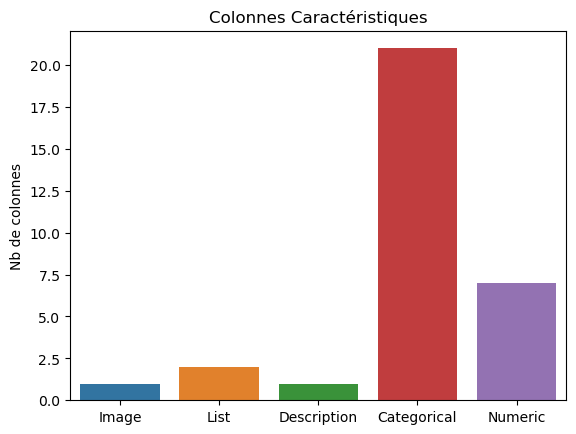

In [43]:
categorical_cols = bool_cols + object_cols 

plt.title("Colonnes Caractéristiques")
plt.ylabel("Nb de colonnes")
sns.barplot(x= ['Image', 'List', 'Description', 'Categorical', 'Numeric'], y = [len(image_cols), len(list_cols), len(desc_cols), len(categorical_cols), len(numeric_cols) ], )


## Similarités entre les annonces immobilières :

### Comparaison entre les liens images : 

Nous considérons que deux annonces sont associées au même bien immobilier si :

- "IMAGES" : Leurs liens images ont une intersection non nulle, et en plus, nous imposons qu'ils partagent au moins 2 liens en commun pour éviter le cas des photos publicitaires (voir l'exemple des annonces 26 et 687).

**Remarques :** Puisque certains liens d'images, par exemple ceux du LE BON COIN 14, ne sont plus accessibles, nous nous contentons de comparer les liens au lieu de visualiser leurs photos contenues.

In [44]:
def common_links(a, b):
    a_set = set(a)
    b_set = set(b)
    if len(a_set.intersection(b_set))>=2:
        return True
    else:
        return False

In [45]:
def compare_image(df, icols, i, j):
    for k in icols:
        i_links = json.loads(df.loc[i, k])
        j_links = json.loads(df.loc[j, k])
        return common_links(i_links, j_links)
    

Exemples :

In [46]:
compare_image(X, image_cols, 26, 687), compare_image(X, image_cols, 3, 85)

(False, True)

In [47]:
output = []
for j in X.index:
    if compare_image(X, image_cols, 3, j):
        output.append(j)

print(output)

[3, 85, 493, 1119, 1548, 1845, 1866]


In [48]:
json.loads(X.loc[3, "IMAGES"])

['https://pix.yanport.com/ads/e9e07ed0-812f-11e8-82aa-61eacebe4584/image_fc7d9181f6042f4a630c7fdbc9f40ba3.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/j/4/5/1j4582b04i58fwekzdtgiu20uqw3a640e7w3papd4.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/y/c/d/1ycdcnohlrp0qttlt6edgfs4cjajfz8nmo02ox7fs.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/p/0/1/1p01zgt2uxdey4rb322p2lk8iq17l1c8w1ukk6bjc.jpg',
 'https://v.seloger.com/s/width/800/visuels/0/g/d/o/0gdod5pizzrepy7g3gi4h4aq4b34ycr2lq6do10bs.jpg',
 'https://v.seloger.com/s/width/800/visuels/2/0/o/g/20ogztaombstv4wfenyhqgj3r906mur2vbbvp70jw.jpg']

In [49]:
json.loads(X.loc[85, "IMAGES"])

['https://pix.yanport.com/ads/ac3439f0-812f-11e8-82aa-61eacebe4584/image_685502e001f0730593f66ff91b4f1c1a.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/p/0/1/1p01zgt2uxdey4rb322p2lk8iq17l1c8w1ukk6bjc.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/y/c/d/1ycdcnohlrp0qttlt6edgfs4cjajfz8nmo02ox7fs.jpg',
 'https://v.seloger.com/s/width/800/visuels/0/g/d/o/0gdod5pizzrepy7g3gi4h4aq4b34ycr2lq6do10bs.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/n/1/y/1n1ycskv7p348kabig6p2bbnz4kwo3umpscyhdr6w.jpg',
 'https://v.seloger.com/s/width/800/visuels/1/j/4/5/1j4582b04i58fwekzdtgiu20uqw3a640e7w3papd4.jpg',
 'https://v.seloger.com/s/width/800/visuels/2/0/o/g/20ogztaombstv4wfenyhqgj3r906mur2vbbvp70jw.jpg']

### Comparaison des textes des descriptions :

Nous utilisons un modèle de langage de base SentenceTransformer. Tout d'abord, nous calculons les longueurs maximales des descriptions :

In [50]:
max_length =0
for i in X.index:
    desc = X.loc[i, "DESCRIPTION"]
    max_length = max(max_length, len(desc))
print(s)

model = CrossEncoder('dangvantuan/CrossEncoder-camembert-large', max_length=max_length)

[]


Limité par le modèle et la puissance de mon propre ordinateur portable, nous choisissons ici de prendre en compte seulement des 800 premiers caractères pour estimer les similarités entre deux textes.

In [51]:
def compare_desc(df, dcols, i, j):
    df["DESCRIPTION"].astype('string')
    i_desc = str(df.loc[i, "DESCRIPTION"]).lower()[0:800]
    j_desc = str(df.loc[j, "DESCRIPTION"]).lower()[0:800]
    return  (model.predict([i_desc, j_desc]))


Les exemples avec les annonces (26, 687) et (58, 762) :

In [52]:
compare_desc(X, desc_cols, 26, 687), compare_desc(X, desc_cols, 58, 762)

(0.43317997, 0.9946484)


### Comparaison des colonnes catégoriques :

Nous considérons que deux annonces ne sont pas associées au même bien immobilier s'il y a plus de **deux** valeurs distinctes dans les colonnes catégoriques.

In [53]:
def compare_cat(df, ccols, i, j): 
    i_list = df.loc[i, ccols].to_list()
    j_list = df.loc[j, ccols].to_list()
    result =0
    k = 0 # compteur des comparaisons valables
    while (result <= 1) and (k<len(ccols)):
        i_k = i_list[k]
        j_k = j_list[k]
        if not pd.isnull(i_k) and not pd.isnull(j_k):
            result += (i_k != j_k)
        k += 1

    return (result <=1)

Encore les fameux exemples avec (26, 687) et (58, 762) :

In [54]:
compare_cat(X, categorical_cols, 26, 687), compare_cat(X, categorical_cols, 58, 762),

(False, True)

### Comparaison des colonnes numériques et listes

In [55]:
print(list_cols, numeric_cols)

['HEATING_TYPES', 'PRICE_EVENTS'] ['SURFACE', 'LAND_SURFACE', 'TERRACE_SURFACE', 'PRICE_M2', 'RENTAL_EXPENSES', 'DEPOSIT', 'FEES']


In [56]:
def compare_list(df, lcols, i, j):
    i_heat = set(json.loads(df.loc[i, "HEATING_TYPES"]))
    j_heat = set(json.loads(df.loc[j, "HEATING_TYPES"]))
    if not (i_heat.issubset(j_heat) or j_heat.issubset(i_heat)):
        return False
    else: 
        i_price_ev= json.loads(df.loc[i, "PRICE_EVENTS"])
        j_price_ev = json.loads(df.loc[j, "PRICE_EVENTS"])

        i_price = i_price_ev[-1]['price']
        j_price = j_price_ev[-1]['price']
        return (abs(i_price - j_price) <5)

In [57]:
compare_list(X, list_cols, 26, 687), compare_cat(X, list_cols, 58, 762),

(False, True)

In [58]:
def compare_num(df, ncols, i, j):
    criteria = 0 
    k = 0 # compteur des comparisons valables

    # SURFACE
    i_surf = df.loc[i, "SURFACE"]
    j_surf = df.loc[j, "SURFACE"]
    if pd.notnull(i_surf) and pd.notnull(j_surf):
        criteria += (abs(i_surf - j_surf) <= 1)
        k+= 1

    # LAND SURFACE 
    i_land = df.loc[i, "LAND_SURFACE"]
    j_land = df.loc[j, "LAND_SURFACE"]
    if pd.notnull(i_land) and pd.notnull(j_land):
        criteria += (abs(i_land - j_land) <= 1)
        k+= 1

    # TERRACE SURFACE
    i_terrace = df.loc[i, "TERRACE_SURFACE"]
    j_terrace = df.loc[j, "TERRACE_SURFACE"]
    if pd.notnull(i_terrace) and pd.notnull(j_terrace):
        criteria += (abs(i_terrace - j_terrace) <= 1)
        k+= 1

    # PRICE M2
    i_pricem2 = df.loc[i, "PRICE_M2"]
    j_pricem2 = df.loc[j, "PRICE_M2"]
    if pd.notnull(i_pricem2) and pd.notnull(j_pricem2):
        criteria += (abs(i_pricem2 - j_pricem2) <= 5)
        k+= 1
    
    # RENTAL_EXPENSES
    i_rent = df.loc[i, "RENTAL_EXPENSES"]
    j_rent = df.loc[j, "RENTAL_EXPENSES"]
    if pd.notnull(i_rent) and pd.notnull(j_rent):
        criteria += (abs(i_rent - j_rent) <= 5)
        k+= 1


    # FEES
    i_fees = df.loc[i, "FEES"]
    j_fees = df.loc[j, "FEES"]
    if pd.notnull(i_fees) and pd.notnull(j_fees):
        criteria += (abs(i_fees - j_fees) <= 5)
        k+= 1

    # DEPOSIT 
    i_deposit = df.loc[i, "DEPOSIT"]
    j_deposit = df.loc[j, "DEPOSIT"]
    if pd.notnull(i_deposit) and pd.notnull(j_deposit):
        criteria += (abs(i_deposit - j_deposit) <= 5)
        k+= 1


    return (criteria > (k/2)) # retourner true si la moitié de comparaisons valables sont true
    

Exemples :

In [59]:
compare_num(X, numeric_cols, 26, 687), compare_num(X, numeric_cols, 58, 762),

(False, True)

## Création des clés de regroupement

Nous disposons maintenant de toutes les fonctions de critères/comparaisons et nous sommes en mesure de regrouper les annonces qui se rapportent au même bien immobilier.

In [60]:
def same_real_estate(df, icols, dcols, ccols, lcols, ncols, i, j):
    if compare_image(df, icols, i, j):
        return True
    elif compare_cat(df, ccols, i, j): 
        if compare_list(df, lcols, i, j) and compare_num(df, ncols, i, j):
            return (compare_desc(df, dcols, i, j) >= 0.85)
    else:
        return False

Nous soulignons que l'on  compare les descriptions texte seulement au moment où nous n'arrivons pas à distincter deux annonces avec les autres colonnes caractéristiques. Nous mettre le seuil **0.85** pour dire comme quoi 2 annonces sont associées au même bien immobilier, mais ce choix du seuil n'est pas impartial. Nous revenons à ce seuil à la fin, et nous discuterons des possibilités pour rendre ce choix plus neutre et objectif.

In [61]:
same_real_estate(X, image_cols, desc_cols, categorical_cols, list_cols, numeric_cols, 3, 85)

True

In [62]:

same_real_estate(X, image_cols, desc_cols, categorical_cols, list_cols, numeric_cols, 26, 687)

False

In [63]:
same_real_estate(X, image_cols, desc_cols, categorical_cols, list_cols, numeric_cols, 58, 762)

True

Enfin, nous exécutons une boucle for : pour chaque annonce, si la clé n'a pas encore été attribuée, nous utilisons son "ID" comme clé et examinons si les annonces ultérieures sont associée au même bien immobilier.

In [64]:
def df_with_keys(df = X, icols = image_cols, dcols = desc_cols, ccols = categorical_cols, lcols = list_cols, ncols = numeric_cols): 
    Y = df.copy()
    Y['KEY'] = pd.Series(dtype='object')
    for i in Y.index : 
        if pd.isnull(Y.loc[i, 'KEY']):
            Y.loc[i, 'KEY'] = Y.loc[i, 'ID']
            for j in range(i+1, len(Y.index)) :
                if same_real_estate(df, icols, dcols, ccols, lcols, ncols, i, j):
                    Y.loc[j, 'KEY'] = Y.loc[i, 'KEY']
    return Y

        

Mise en action !

In [65]:
X_with_keys = df_with_keys(X)
print(X_with_keys)
# X_with_keys["KEY"].nunique()

                                        ID  \
0     22c05930-0eb5-11e7-b53d-bbead8ba43fe   
1     8d092fa0-bb99-11e8-a7c9-852783b5a69d   
2     44b6a5c0-3466-11e9-8213-25cc7d9bf5fc   
3     e9e07ed0-812f-11e8-82aa-61eacebe4584   
4     872302b0-5a21-11e9-950c-510fefc1ed35   
...                                    ...   
2159  d3579370-824f-11e9-af18-9742751bcff8   
2160  cce3fc60-c86b-11e9-a6b2-651beb16710e   
2161  beec50b0-c85e-11e9-92d3-cb429fb9e457   
2162  8cba88c0-a07a-11e9-a8e6-0de7b497e456   
2163  f3ae8be0-9fcf-11e9-ab3e-47ec2b68d334   

                                                    URL PROPERTY_TYPE  \
0     http://www.avendrealouer.fr/location/levallois...     APARTMENT   
1     https://www.bienici.com/annonce/ag440414-16547...     APARTMENT   
2     https://www.bellesdemeures.com/annonces/vente/...     APARTMENT   
3     https://www.seloger.com/annonces/locations/bur...      PREMISES   
4     https://www.bellesdemeures.com/annonces/vente/...         HOUSE   
...      

In [66]:
X_with_keys["KEY"].value_counts()

KEY
ddc272a0-3991-11e9-8a1a-297fbcac27e2    43
57baa230-c862-11e9-a6b2-651beb16710e     7
bde25540-c4f1-11e9-a6b2-651beb16710e     7
872302b0-5a21-11e9-950c-510fefc1ed35     7
78e1ca10-35a5-11e9-8a1a-297fbcac27e2     7
                                        ..
e6511700-349b-11e9-8213-25cc7d9bf5fc     1
6fc4cb10-8c6e-11e9-a7f2-f5443208fc78     1
990b3520-ab51-11e9-aa5e-8b8909b4f047     1
d04cd4f0-a28f-11e9-aa5e-8b8909b4f047     1
8cba88c0-a07a-11e9-a8e6-0de7b497e456     1
Name: count, Length: 1484, dtype: int64

## Sortie des données 

In [67]:
df_with_keys = df.copy()
df_with_keys["KEY"] = X_with_keys["KEY"]

df_with_keys.to_csv('./submission.csv')

## Piste d'amélioration : 

À la fin de cette étude, nous proposons quelques pistes d'amélioration. Certaines n'ont pas pu être réalisées en raison du manque de temps ou de ressources disponibles :

* **Dans cette étude**, en raison du manque de données suffisantes, nous avons utilisé un modèle pré-entraîné pour évaluer les similarités entre les textes des descriptions. 
Nous avons choisi un seuil de 0,85 pour déterminer si deux descriptions sont similaires ou non. Une manière de rendre ce choix plus rigoureux serait de réaliser une méthode de "minmax" itératif sur un sous-ensemble des données, plus concrètement,


In [68]:

import random
def seuil(df, n, p): 
# n = nb de fois d'iteration, p nb de sous-ensemble pris pour estimer le seuil
    seuil_list = []
    for k in range(n):
        max_score = 0
        L = random.sample(list(df.index), p)
        for i in range(p):
            for j in range(i+1, p):
                max_score = max(max_score, compare_desc(df, desc_cols, i, j))
        seuil_list.append(max_score)
    return min(seuil_list)


Par exemple, nous pourrions calculer le score maximal sur un ensemble de 50 données aléatoires, puis prendre le minimum sur les 5 itérations :

In [69]:
seuil(X, 5, 50)

0.8465062

* Critère de confiance : Il serait possible d'ajouter une pondération pour améliorer la précision de l'identification. On pourrait s'attendre à une combinaison linéaire ou non linéaire des fonctions comparatives. Si nous disposions de suffisamment de données d'entraînement et de validation, nous pourrions tenter de trouver les coefficients de pondération pour les fonctions de comparaison d'images, de listes, de catégories, de numéros et de descriptions. Cela permettrait également de minimiser l'impact des saisies incorrectes.

* Analyse des photos : Il serait possible d'exploiter les informations utiles contenues dans les images, mais cela dépendrait de la qualité et des conditions de prise de vue des photos. (par exemple, la luminosité lors de la capture de l'extérieur du bâtiment le matin)

* Analyse Géo-spatiale : Intégrer des données géospatiales pour affiner les regroupements en fonction de la localisation.

* Correction des mauvaises saisies (typographie, fuzzywuzzy) : Mettre en place des mécanismes de correction automatique pour les saisies incorrectes.
